# Capstone Project - Toronto Airbnb and nearby venues

### Michaela Solomon
### Applied Data Science Capstone - IBM Coursera

## Introduction: Business Problem <a name="introduction"></a>

<p>Airbnb is an online marketplace where millions of hosts and travellers can create a free account so they can list their space or book accommodations anywhere in the world. It covers more than 100,000 cities and 220 countries worldwide.</p> <p>Airbnb has been successful because it has managed to replace hotels as a traditional method of accommodation for travellers worldwide.</p><p>Being one of the most popular tourist destination in Canada, Toronto’s AirBnb market has been growing with an increased number of hosts joining and listing their homes for rent.</p><p>For this Capstone Project the business need is to provide the travellers with relevant information about Airbnb offers and venues in Toronto.</p><p>The listing price and amenities are an important factor in choosing a rental, but location is also important. Using FourSquare API venues data to compare different neighbourhoods could be a good opportunity to choose, for example, an area with good restaurants or concert halls or shopping centers.</p><p>The results will be presented as a map that will group by boroughs the number of offers, average price, and top 5 venues.<p>

## Data <a name="data">

<p>The data source for Toronto’s Airbnb is provided by <b></b> website: <a href="http://data.insideairbnb.com/canada/on/toronto/2021-01-02/data/listings.csv.gz">Inside Airbnb</a></p>
<p>The data set has <b>74 columns</b> and <b>18265 entries</b>. I’ll be using only the following columns in order to get insight about the price listings, which neighbourhood has the most amount of listings, number of reviews, neighbourhoods, etc.:</p>  
<p><i>'neighbourhood_cleansed', 'latitude', 'longitude', 'room_type', 'price'</i></p>
<p>I’ll check the data for null values and remove or fill them, by case.</p>
After cleaning this data set, I’ll join it with the Geospatial data from <a href="https://cocl.us/Geospatial_data">Week3</a> by latitude/longitude to find the postal code for each neighbourhood.
<p>The data for Toronto’s neighbourhoods is extracted from <a href="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M">Wikipedia</a> and it was used in the week3 assignment.</p>
<p>Using the <b>FourSquare API</b> I’m going to retrieve information about each neighbourhood venue categories, such as: restaurants, shopping centres, museums, parks, recreation places, etc.</p>


### Import all the libraries that we will need

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
#import geopandas as gpd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library for handling JSON files
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't installed geopy yet
import geocoder
from geopy.geocoders import Nominatim # library that convserts an address into longitude and latitude values
import requests # library to handle requests
from pandas import json_normalize # library to tranform JSON file into a pandas dataframe

import math
import seaborn as sns

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncoment this line if you haven't installed it yet
import folium # map rendering library
from folium import Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

print('Libraries imported.')

Libraries imported.


In [2]:
# to make this notebook's output identical at every run
np.random.seed(42)

#### Read the Toronto airbnb into a pandas dataframe

In [3]:
#listing_df = pd.read_csv('http://data.insideairbnb.com/canada/ontoronto/2021-01-02/data/listings.csv.gz', compression='gzip')
listing_df = pd.read_csv("data/listing/listings.csv")

In [4]:
listing_df.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1419,https://www.airbnb.com/rooms/1419,20210102020445,2021-01-02,Beautiful home in amazing area!,"This large, family home is located in one of T...",The apartment is located in the Ossington stri...,https://a0.muscache.com/pictures/76206750/d643...,1565,https://www.airbnb.com/users/show/1565,Alexandra,2008-08-08,"Vancouver, British Columbia, Canada","I live in Vancouver, Canada with my husband an...",NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/7aeea...,https://a0.muscache.com/im/pictures/user/7aeea...,Commercial Drive,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Toronto, Ontario, Canada",Little Portugal,NaN,43.64617,-79.42451,Entire house,Entire home/apt,10,NaN,3 baths,5.0,7.0,"[""Dryer"", ""Washer"", ""TV"", ""Shampoo"", ""Air cond...",$469.00,4,730,4,4,730,730,4.0,730.0,NaN,t,0,0,0,0,2021-01-02,7,0,0,2015-07-19,2017-12-04,100.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,f,1,1,0,0,0.11
1,8077,https://www.airbnb.com/rooms/8077,20210102020445,2021-01-04,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,NaN,https://a0.muscache.com/pictures/11780344/141c...,22795,https://www.airbnb.com/users/show/22795,Kathie & Larry,2009-06-22,"Toronto, Ontario, Canada",My husband and I have been airbnb host for alm...,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/9a077...,https://a0.muscache.com/im/pictures/user/9a077...,Harbourfront,2.0,2.0,"['email', 'phone', 'facebook', 'reviews']",t,f,NaN,Waterfront Communities-The Island,NaN,43.64105,-79.37628,Private room in apartment,Private room,2,NaN,1.5 baths,1.0,1.0,"[""Gym"", ""Elevator"", ""Air conditioning"", ""Wifi""...",$96.00,180,365,180,180,365,365,180.0,365.0,NaN,t,30,60,90,365,2021-01-04,169,0,0,2009-08-20,2013-08-27,97.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,t,2,1,1,0,1.22
2,12604,https://www.airbnb.com/rooms/12604,20210102020445,2021-01-02,Seaton Village Parlour Bedroom,Comfortable sofa bed in airy main floor parlou...,NaN,https://a0.muscache.com/pictures/5282025/91fca...,48239,https://www.airbnb.com/users/show/48239,Rona,2009-10-25,"Toronto, Ontario, Canada","I love travelling and exploring new places, ma...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/48239/profile...,https://a0.muscache.com/im/users/48239/profile...,The Annex,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,NaN,Annex,NaN,43.66724,-79.41598,Private room in house,Private room,1,NaN,1.5 baths,1.0,1.0,"[""Wifi"", ""Indoor fireplace""]",$64.00,1,10,1,1,10,10,1.0,10.0,NaN,t,0,0,0,0,2021-01-02,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
3,23691,https://www.airbnb.com/rooms/23691,20210102020445,2021-01-03,Queen Bedroom close to downtown,<b

## Data exploration and analisys

#### Create a new dataframe with the following columns:  
'neighbourhood_cleansed', 'latitude', 'longitude', 'room_type', 'price'

In [5]:
tobnb=listing_df[['neighbourhood_cleansed', 'latitude', 'longitude', 'room_type', 'price']]

In [6]:
tobnb.head()

,neighbourhood_cleansed,latitude,longitude,room_type,price
0,Little Portugal,43.64617,-79.42451,Entire home/apt,$469.00
1,Waterfront Communities-The Island,43.64105,-79.37628,Private room,$96.00
2,Annex,43.66724,-79.41598,Private room,$64.00
3,Briar Hill-Belgravia,43.69602,-79.45468,Private room,$70.00
4,Greenwood-Coxwell,43.66890,-79.32592,Entire home/apt,$45.00


In [7]:
tobnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18265 entries, 0 to 18264
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   neighbourhood_cleansed  18265 non-null  object 
 1   latitude                18265 non-null  float64
 2   longitude               18265 non-null  float64
 3   room_type               18265 non-null  object 
 4   price                   18265 non-null  object 
dtypes: float64(2), object(3)
memory usage: 713.6+ KB


In [8]:
len(tobnb)

18265

**Checking for null values**

In [9]:
tobnb[tobnb.isnull().any(axis=1)]

,neighbourhood_cleansed,latitude,longitude,room_type,price


### Cleaning the columns:
Remove unwanted characters `$`, `,` from `price` column, then  
convert it to int type -- currently is of object type

In [10]:
tobnb['price']=tobnb['price'].map(lambda x: x.lstrip('$'))
tobnb['price']=tobnb['price'].str.replace(",", "")
tobnb['price']=tobnb['price'].map(lambda x: int(float(x)))

<ipython-input-10-4475ffdac8f5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tobnb['price']=tobnb['price'].map(lambda x: x.lstrip('$'))
<ipython-input-10-4475ffdac8f5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tobnb['price']=tobnb['price'].str.replace(",", "")
<ipython-input-10-4475ffdac8f5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

### Sort by price and find where the most expensive/least expensive airnb are located

In [11]:
# The most expensive airbnb in Toronto GTA area
tobnb.loc[tobnb['price'].idxmax()]
tobnb.sort_values('price',ascending=False).iloc[:10,]

,neighbourhood_cleansed,latitude,longitude,room_type,price
14764,Woburn,43.78046,-79.24929,Entire home/apt,13000
9238,Newtonbrook West,43.78659,-79.42741,Entire home/apt,13000
6126,Waterfront Communities-The Island,43.64836,-79.39181,Entire home/apt,13000
4411,Annex,43.67250,-79.39515,Entire home/apt,12728
11592,Palmerston-Little Italy,43.65781,-79.42000,Entire home/apt,12400
8508,Niagara,43.63538,-79.40433,Entire home/apt,11500
12324,Waterfront Communities-The Island,43.64184,-79.38189,Entire home/apt,10000
4897,Clanton Park,43.73056,-79.45783,Private room,7500
7399,Waterfront Communities-The Island,43.64476,-79.39738,Entire home/apt,6848
13039,Waterfront Communities-The Island,43.64744,-79.36537,Entire home/apt,5000


In [12]:
# The cheapest airbnb
tobnb.loc[tobnb['price'].idxmin()]
tobnb.sort_values('price',ascending=True).iloc[:10,]

,neighbourhood_cleansed,latitude,longitude,room_type,price
15413,Hillcrest Village,43.79633,-79.34674,Hotel room,0
15793,Waterfront Communities-The Island,43.65444,-79.35632,Hotel room,0
10803,Willowdale East,43.75736,-79.40424,Entire home/apt,13
5470,Don Valley Village,43.77583,-79.34800,Shared room,13
10717,Don Valley Village,43.77915,-79.35169,Private room,13
15760,Malvern,43.80566,-79.22710,Shared room,13
4431,Yonge-St.Clair,43.69504,-79.39818,Shared room,13
11400,Rexdale-Kipling,43.71711,-79.56036,Shared room,13
6991,Lansing-Westgate,43.76462,-79.41368,Private room,13
15632,Malvern,43.80369,-79.22831,Shared room,14


### Create the histogram to visualize the price distribution

137.6596222283055

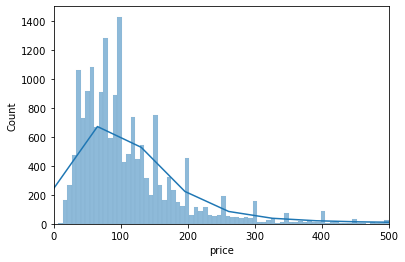

In [13]:
sns.histplot(data=tobnb, x="price", kde=True)
plt.xlim(0,500)
tobnb.price.mean()

Let's create the price distribution for the top 10 neighbourhoods with the most listings

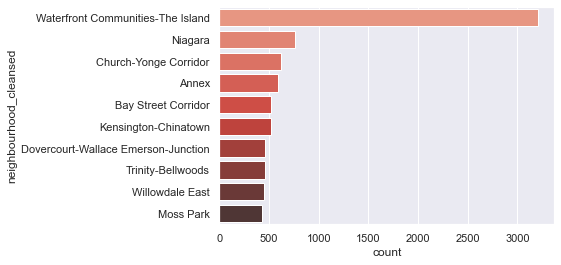

In [14]:
sns.set_theme(style = 'darkgrid')
neighourhood_count = sns.countplot(y='neighbourhood_cleansed',data=tobnb, palette='Reds_d',order=tobnb.neighbourhood_cleansed.value_counts().iloc[:10].index)

We now calculate the average price for the top ten Toronto neighbourhoods airbnb listings.

In [15]:
top_ten_neighbourhoods = ['Waterfront Communities-The Island','Niagara','Church-Yonge Corridor','Annex',
                          'Bay Street Corridor','Kensington-Chinatown','Dovercourt-Wallace Emerson-Junction',
                          'Trinity-Bellwoods','Willowdale East','Moss Park']
sub = tobnb[tobnb.neighbourhood_cleansed.isin(top_ten_neighbourhoods)]
avgprice = sub.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False)
avgprice

neighbourhood_cleansed
Waterfront Communities-The Island      195.546729
Niagara                                187.755263
Annex                                  177.899317
Moss Park                              149.810624
Bay Street Corridor                    143.007707
Trinity-Bellwoods                      128.799564
Kensington-Chinatown                   128.550388
Church-Yonge Corridor                  128.360709
Willowdale East                        113.933036
Dovercourt-Wallace Emerson-Junction    100.848485
Name: price, dtype: float64

In [16]:
sub.head()

,neighbourhood_cleansed,latitude,longitude,room_type,price
1,Waterfront Communities-The Island,43.64105,-79.37628,Private room,96
2,Annex,43.66724,-79.41598,Private room,64
5,Waterfront Communities-The Island,43.64151,-79.37643,Entire home/apt,127
8,Waterfront Communities-The Island,43.64451,-79.38185,Entire home/apt,115
10,Church-Yonge Corridor,43.66979,-79.38494,Entire home/apt,99


In [17]:
def embed_map(m, file_name):
    from IPython.display import IFrame
    m.save(file_name)
    return IFrame(file_name, width='100%', height='300px')

#### Map visualization using folium for the top ten Toronto neighbourhoods

In [18]:
address = 'Toronto, ON'
geolocator = Nominatim(user_agent='to_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Toronto are {}, {}'.format(latitude, longitude))

The geographical coordinates of Toronto are 43.6534817, -79.3839347


In [19]:
top_ten_map = folium.Map(location = [latitude, longitude], zoom_start=13)
top_ten_marker_cluster = MarkerCluster().add_to(top_ten_map)

# add markers to map
for lat, lng, neighbourhood, price in zip(sub['latitude'], sub['longitude'], sub['neighbourhood_cleansed'], sub['price']):
    label='neighbourhood: {}, price: {}'.format(neighbourhood, price)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
                       radius=5,
                       popup=label,
                       color='blue',
                       fill=True,
                       fill_color='#318cc',
                       fill_opacity=0.7,
                       parse_html=False).add_to(top_ten_marker_cluster)

#map_toronto
embed_map(top_ten_map,'top_ten_map.html')

### For the purpose of this project we are going to use only the first three neighbourhoods that have more than 500 listings  
**Now, we are going to get the postal codes for each listing  
First, we create a helper function that gets the postal code for a location based on latitude and longitude**

In [21]:
top_three_neighbourhoods = ['Waterfront Communities-The Island','Niagara','Church-Yonge Corridor']
top_three = tobnb[tobnb.neighbourhood_cleansed.isin(top_three_neighbourhoods)]
av_price = top_three.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False)
av_price

neighbourhood_cleansed
Waterfront Communities-The Island    195.546729
Niagara                              187.755263
Church-Yonge Corridor                128.360709
Name: price, dtype: float64

In [24]:
def get_postCodeGoogle(lat, lon):
    postal_code=None
    while(postal_code is None):
        g = geocoder.google([lat, lon], method='reverse')
        #g=geocoder.arcgis([lat, lon], method='reverse')
        #postal_code=g.postal
        key='postal'
        if key in g.geojson['features'][0]['properties']:
            postal_code = g.geojson['features'][0]['properties']['postal'][0:3]
            #str1=g.geojson['features'][0]['properties']['postal']
            #postal_code=str1[0:3]
        else:
            postal_code=None

    return postal_code

get_postCodeGoogle(43.64617,-79.42451)

'M6J'

In [22]:
top_three.shape

(4591, 5)

In [23]:
top_three.head(3)

,neighbourhood_cleansed,latitude,longitude,room_type,price
1,Waterfront Communities-The Island,43.64105,-79.37628,Private room,96
5,Waterfront Communities-The Island,43.64151,-79.37643,Entire home/apt,127
8,Waterfront Communities-The Island,43.64451,-79.38185,Entire home/apt,115


In [ ]:
# Retreaving Postal Codes  -- this code was run previously
#postalcodes=[get_postCodeGoogle(lat, lon) for lat, lon in zip(top_three['latitude'], top_three['longitude'])]

In [ ]:
#postalcodes

In [ ]:
#Save to a file  -- this code was run previously
#df = pd.DataFrame(postalcodes)

#df.to_csv('topthree_postalcodes.csv', index=False, header=True)

In [25]:
# read the saved codes file. It takes too long to run the code that regenerates the postal codes.
# I ran the code once and for the further developing my code I'll use the saved file.
codes=pd.read_csv('topthree_postalcodes.csv')
codes.head()

,Postal Codes
0,M5J
1,M5E
2,M5J
3,M4Y
4,M4W


In [ ]:
# Adding column PostalCode

In [26]:
#df_postalcodes=pd.DataFrame(postalcodes, columns=['Postal Code'])
top_three['Postal Code']=codes['Postal Codes']

<ipython-input-26-70b3379c8f75>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_three['Postal Code']=codes['Postal Codes']


In [27]:
top_three.head()

,neighbourhood_cleansed,latitude,longitude,room_type,price,Postal Code
1,Waterfront Communities-The Island,43.64105,-79.37628,Private room,96,M5E
5,Waterfront Communities-The Island,43.64151,-79.37643,Entire home/apt,127,M4Y
8,Waterfront Communities-The Island,43.64451,-79.38185,Entire home/apt,115,M6J
10,Church-Yonge Corridor,43.66979,-79.38494,Entire home/apt,99,M6J
14,Church-Yonge Corridor,43.66957,-79.38539,Private room,86,M5V


In [28]:
# Create a copy
top_three_new=top_three.copy()

In [29]:
top_three_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4591 entries, 1 to 18264
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   neighbourhood_cleansed  4591 non-null   object 
 1   latitude                4591 non-null   float64
 2   longitude               4591 non-null   float64
 3   room_type               4591 non-null   object 
 4   price                   4591 non-null   int64  
 5   Postal Code             1143 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 251.1+ KB


In [41]:
top_three_new = top_three_new.reset_index(drop=True)
top_three_new.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
top_three_new.head(3)

,neighbourhood_cleansed,latitude,longitude,room_type,price,PostalCode
0,Waterfront Communities-The Island,43.64105,-79.37628,Private room,96,M5E
1,Waterfront Communities-The Island,43.64151,-79.37643,Entire home/apt,127,M4Y
2,Waterfront Communities-The Island,43.64451,-79.38185,Entire home/apt,115,M6J


### Let's find what borough coresponds to each listing

**Use the Notebook to build the code to scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas  dataframe**

In [30]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
dfs=pd.read_html(url, header=0)
print("number of tables: " + str(len(dfs)))

number of tables: 3


**Create the dataframe:**  
- The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood

In [31]:
dff=dfs[0] # get the first table
dff.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [32]:
# check for null values
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Postal Code    180 non-null    object
 1   Borough        180 non-null    object
 2   Neighbourhood  180 non-null    object
dtypes: object(3)
memory usage: 4.3+ KB


**Only process the cells that have an assigned borough. Ignore cells with a borough that is _Not assigned_**.

In [34]:
dff.drop(dff.index[dff['Borough'] == 'Not assigned'], inplace=True)

dff = dff.reset_index(drop=True)
dff.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
dff.head(3)

,PostalCode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"


**Checking for Postal Code duplicates and if exist the rows will be combined into one row with the neighborhoods separated with a comma**

In [35]:
df_postcode = dff.groupby(['PostalCode', 'Borough'])['Neighbourhood'].apply(', '.join).reset_index()

df_postcode.head(3)

,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"


In [36]:
df_postcode.shape

(103, 3)

**Check if a cell has a borough but a Not assigned  neighborhood, then the neighborhood will be the same as the borough.**

In [37]:
df_replace = df_postcode.replace({'Neighbourhood':'Not assigned'}, df_postcode['Borough'])
df_replace.head(11)

,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park"
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge"
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


#### Read the Geospatial_data csv file that has the geographical coordinates of each postal code:` http://cocl.us/Geospatial_datafile ` 

In [38]:
df_latlong = pd.read_csv('https://cocl.us/Geospatial_data', index_col='Postal Code')

In [39]:
df_latlong.head()

,Latitude,Longitude
Postal Code,,
M1B,43.806686,-79.194353
M1C,43.784535,-79.160497
M1E,43.763573,-79.188711
M1G,43.770992,-79.216917
M1H,43.773136,-79.239476


**Join both the dataframes on `Postal Code` column**

In [40]:
toronto_data = df_replace.join(df_latlong, on='PostalCode')
toronto_data.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


### Merge on postal code with airbnb listings

In [42]:
# merge on neighborhoods
merged_df = top_three_new.merge(toronto_data, on='PostalCode', how='inner')
merged_df.head()

,neighbourhood_cleansed,latitude,longitude,room_type,price,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,Waterfront Communities-The Island,43.64105,-79.37628,Private room,96,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
1,Waterfront Communities-The Island,43.64366,-79.39155,Entire home/apt,199,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
2,Waterfront Communities-The Island,43.64456,-79.39449,Entire home/apt,145,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
3,Niagara,43.63690,-79.42002,Entire home/apt,86,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
4,Niagara,43.64247,-79.41246,Entire home/apt,229,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


In [43]:
boroughs=merged_df['Borough'].unique()
#print('There are {} unique boroughs.'.format(boroughs))
boroughs

array(['Downtown Toronto', 'West Toronto'], dtype=object)

**Our listings are in two boroughs: Downtown Toronto and West Toronto**  
We are going to analyse only the venues for listings from the Downtown Toronto borough

In [44]:
# Select only entire home/apt room type
listings_downtown = merged_df[(merged_df['Borough'] == 'Downtown Toronto')].reset_index(drop=True)

listings_downtown.rename(columns={'neighbourhood': 'Neighbourhood',
                              'latitude': 'Listing Latitude',
                              'longitude': 'Listing Longitude',
                             'room_type': 'Room Type',
                             'price': 'Price'}, inplace=True)

listings_downtown.head()

,neighbourhood_cleansed,Listing Latitude,Listing Longitude,Room Type,Price,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,Waterfront Communities-The Island,43.64105,-79.37628,Private room,96,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
1,Waterfront Communities-The Island,43.64366,-79.39155,Entire home/apt,199,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
2,Waterfront Communities-The Island,43.64456,-79.39449,Entire home/apt,145,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
3,Niagara,43.63690,-79.42002,Entire home/apt,86,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
4,Niagara,43.64247,-79.41246,Entire home/apt,229,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


In [45]:
listings_downtown.shape

(1037, 10)

### Now we are going to start utilizing the Foursquare API to explore the neighborhoods venues in Downtown Toronto and segment them.  
**Define Foursquare Credentials and Version**

In [46]:
# Loading Foursquare credentials 
import yaml

with open("settings.yaml", 'r') as yamlfile:
    sett = yaml.safe_load(yamlfile)
    
CLIENT_ID = sett['CLIENT_ID']# your Foursquare ID
CLIENT_SECRET = sett['CLIENT_SECRET'] # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
radius = 500 # define radius


In [49]:
downtown_data = toronto_data[toronto_data['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
downtown_data.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529
1,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675
2,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
3,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


**Use the helper function from the course lab to get the nearby venues for the neighbourhoods**

In [47]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [50]:
downtown_toronto_venues = getNearbyVenues(names=downtown_data['Neighbourhood'],
                                   latitudes=downtown_data['Latitude'],
                                   longitudes=downtown_data['Longitude']
                                  )

In [51]:
downtown_toronto_venues.shape

(1222, 7)

In [52]:
# Check total number of venues 
len(downtown_toronto_venues['Venue Category'].unique())

212

In [53]:
downtown_toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Berczy Park,58,58,58,58,58,58
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,65,65,65,65,65,65
Christie,15,15,15,15,15,15
Church and Wellesley,78,78,78,78,78,78
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
"First Canadian Place, Underground city",100,100,100,100,100,100
"Garden District, Ryerson",100,100,100,100,100,100
"Harbourfront East, Union Station, Toronto Islands",100,100,100,100,100,100


In [55]:
downtown_toronto_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale,43.679563,-79.377529,Rosedale Park,43.682328,-79.378934,Playground
1,Rosedale,43.679563,-79.377529,Whitney Park,43.682036,-79.373788,Park
2,Rosedale,43.679563,-79.377529,Alex Murray Parkette,43.678300,-79.382773,Park
3,Rosedale,43.679563,-79.377529,Milkman's Lane,43.676352,-79.373842,Trail
4,"St. James Town, Cabbagetown",43.667967,-79.367675,Cranberries,43.667843,-79.369407,Diner


In [56]:
downtown_toronto_venues['Neighbourhood'].nunique()

19

In [57]:
downtown_toronto_venues['Venue'].nunique()

718

### Merge venues and listings dataframe by neighborhood

In [58]:
# merge on neighborhoods

merged_venues = listings_downtown.merge(downtown_toronto_venues, on='Neighbourhood', how='inner')

# drop borough column 
merged_venues.drop(['Borough'], axis=1, inplace=True)

merged_venues.head()

,neighbourhood_cleansed,Listing Latitude,Listing Longitude,Room Type,Price,PostalCode,Neighbourhood,Latitude,Longitude,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Waterfront Communities-The Island,43.64105,-79.37628,Private room,96,M5E,Berczy Park,43.644771,-79.373306,43.644771,-79.373306,LCBO,43.642944,-79.372440,Liquor Store
1,Waterfront Communities-The Island,43.64105,-79.37628,Private room,96,M5E,Berczy Park,43.644771,-79.373306,43.644771,-79.373306,The Keg Steakhouse + Bar - Esplanade,43.646712,-79.374768,Restaurant
2,Waterfront Communities-The Island,43.64105,-79.37628,Private room,96,M5E,Berczy Park,43.644771,-79.373306,43.644771,-79.373306,Meridian Hall,43.646292,-79.376022,Concert Hall
3,Waterfront Communities-The Island,43.64105,-79.37628,Private room,96,M5E,Berczy Park,43.644771,-79.373306,43.644771,-79.373306,Fresh On Front,43.647815,-79.374453,Vegetarian / Vegan Restaurant
4,Waterfront Communities-The Island,43.64105,-79.37628,Private room,96,M5E,Berczy Park,43.644771,-79.373306,43.644771,-79.373306,Hockey Hall Of Fame (Hockey Hall of Fame),43.646974,-79.377323,Museum


In [60]:
merged_venues.shape

(51248, 15)

In [61]:
merged_venues.duplicated().sum()

0

### Analyze nearby venues

In [62]:
merged_venues['Venue Category'].nunique()

171

In [63]:
merged_venues['Venue'].nunique()

488

In [64]:
merged_venues['Neighbourhood'].nunique()

9

In [65]:
# One hot encoding
toronto_onehot = pd.get_dummies(merged_venues[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = merged_venues['Neighbourhood']

# Move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

In [66]:
toronto_onehot.head()

,Neighbourhood,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Café,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Farmers Market,Fast Food Restaurant,Fish Market,Food & Drink Shop,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Office,Other Great Outdoors,Park,Performing Arts Venue,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Tailor Shop,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Berczy Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Berczy Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Berczy Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Berczy Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,Berczy Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [67]:
toronto_onehot.shape

(51248, 172)

In [68]:
toronto_onehot['Neighbourhood'].nunique()

9

In [69]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return(row_categories_sorted.index.values[0:num_top_venues])

In [70]:
# Grouping each venue category by neighborhood 
# taking mean of the frequency of occurrence of each category
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()

num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Neighbourhood']
for idx in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most common venue'.format(idx+1, indicators[idx]))
    except:
        columns.append('{}th Most common venue'.format(idx+1))
        
# Create a new dataframe 
neighbourhod_venues_sorted = pd.DataFrame(columns=columns)
neighbourhod_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for idx in np.arange(toronto_grouped.shape[0]):
    neighbourhod_venues_sorted.iloc[idx, 1:] = return_most_common_venues(toronto_grouped.iloc[idx, :], num_top_venues)

neighbourhod_venues_sorted.head()

,Neighbourhood,1st Most common venue,2nd Most common venue,3rd Most common venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Bakery
1,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal
2,Church and Wellesley,Coffee Shop,Sushi Restaurant,Japanese Restaurant
3,"Garden District, Ryerson",Clothing Store,Coffee Shop,Bubble Tea Shop
4,"Harbourfront East, Union Station, Toronto Islands",Coffee Shop,Aquarium,Café


In [71]:
neighbourhod_venues_sorted['Neighbourhood'].nunique()

9

### Create Neighbourhoods clusters using `k-means`


In [77]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=25, n_init=10).fit(toronto_grouped_clustering)

# cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 0, 1, 1, 1, 3, 1, 2, 4])

In [84]:
# create df of listings lat/lng only
listings = listings_downtown[['Neighbourhood', 'Listing Latitude', 'Listing Longitude']]
listings.head()

,Neighbourhood,Listing Latitude,Listing Longitude
0,Berczy Park,43.64105,-79.37628
1,Berczy Park,43.64366,-79.39155
2,Berczy Park,43.64456,-79.39449
3,Berczy Park,43.63690,-79.42002
4,Berczy Park,43.64247,-79.41246


In [85]:
listings.shape

(1037, 3)

In [87]:
# add clustering labels
neighbourhod_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge listings and clusters
toronto_merged = listings

# merge data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighbourhod_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head() 

,Neighbourhood,Listing Latitude,Listing Longitude,Cluster Labels,1st Most common venue,2nd Most common venue,3rd Most common venue
0,Berczy Park,43.64105,-79.37628,4,Coffee Shop,Cocktail Bar,Bakery
1,Berczy Park,43.64366,-79.39155,4,Coffee Shop,Cocktail Bar,Bakery
2,Berczy Park,43.64456,-79.39449,4,Coffee Shop,Cocktail Bar,Bakery
3,Berczy Park,43.63690,-79.42002,4,Coffee Shop,Cocktail Bar,Bakery
4,Berczy Park,43.64247,-79.41246,4,Coffee Shop,Cocktail Bar,Bakery


In [88]:
toronto_merged.shape

(1037, 7)

In [89]:
toronto_merged=toronto_merged.dropna()
toronto_merged.shape

(1037, 7)

In [90]:
toronto_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1037 entries, 0 to 1036
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Neighbourhood          1037 non-null   object 
 1   Listing Latitude       1037 non-null   float64
 2   Listing Longitude      1037 non-null   float64
 3   Cluster Labels         1037 non-null   int32  
 4   1st Most common venue  1037 non-null   object 
 5   2nd Most common venue  1037 non-null   object 
 6   3rd Most common venue  1037 non-null   object 
dtypes: float64(2), int32(1), object(4)
memory usage: 60.8+ KB


In [91]:
toronto_merged = toronto_merged.astype({'Cluster Labels': 'int32'})
toronto_merged.head() 

,Neighbourhood,Listing Latitude,Listing Longitude,Cluster Labels,1st Most common venue,2nd Most common venue,3rd Most common venue
0,Berczy Park,43.64105,-79.37628,4,Coffee Shop,Cocktail Bar,Bakery
1,Berczy Park,43.64366,-79.39155,4,Coffee Shop,Cocktail Bar,Bakery
2,Berczy Park,43.64456,-79.39449,4,Coffee Shop,Cocktail Bar,Bakery
3,Berczy Park,43.63690,-79.42002,4,Coffee Shop,Cocktail Bar,Bakery
4,Berczy Park,43.64247,-79.41246,4,Coffee Shop,Cocktail Bar,Bakery


### Create a map to visualize the clusters

In [109]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighbourhood, cluster in zip(toronto_merged['Listing Latitude'], toronto_merged['Listing Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup('Neighbourhood: ' + str(neighbourhood) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
#map_clusters
embed_map(map_clusters,'map_clusters.html')

### Examine clusters

In [96]:
def venue_category_plot(col):
    plt.figure(figsize=(8,6))
    data=df[col].value_counts()
    sns.barplot(x=data.values, y=data.index,  data=df)
    plt.title('List of {}'.format(col), fontsize=14)
    plt.xlabel('Number of venues', fontsize=13)
    plt.xticks(rotation=0)
    plt.show

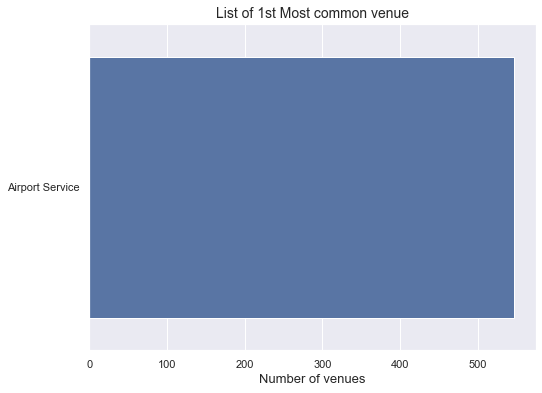

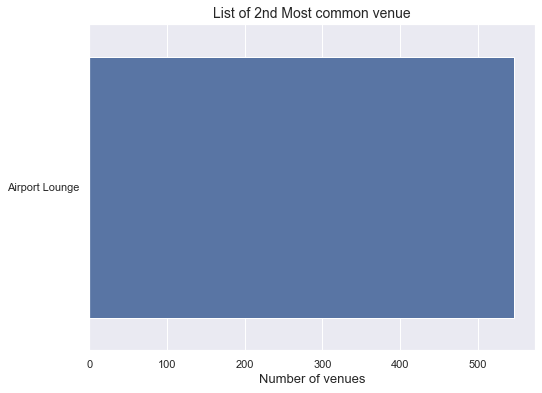

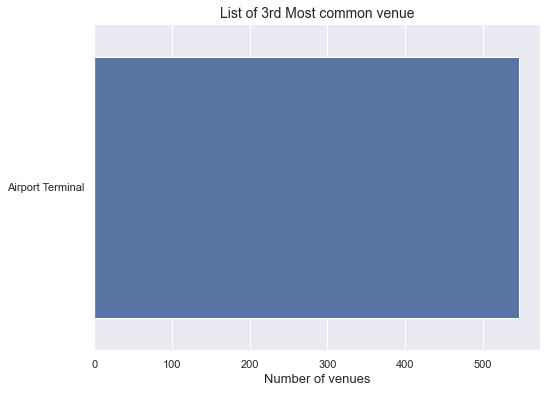

In [97]:
# cluster 0
cluster1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(4, toronto_merged.shape[1]))]]
df = cluster1
for col in df.loc[:, '1st Most common venue':]:
    venue_category_plot(col)

In [104]:
cluster1.shape

(547, 4)

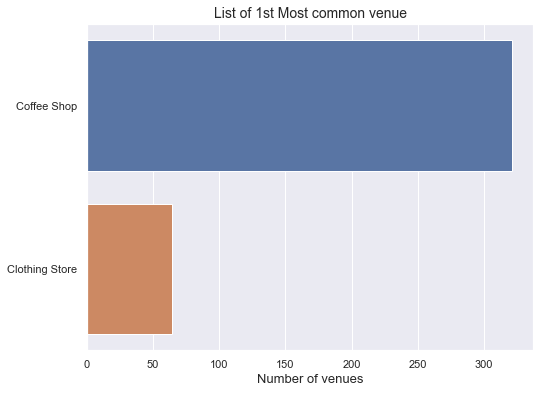

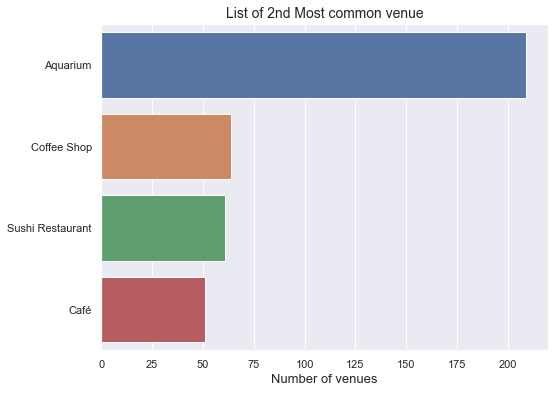

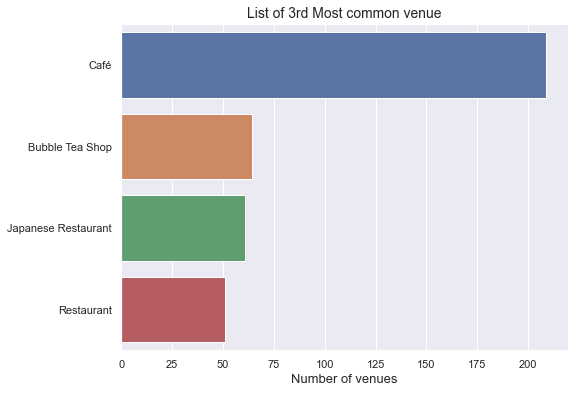

In [98]:
# cluster 1
cluster2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(4, toronto_merged.shape[1]))]]
df = cluster2
for col in df.loc[:, '1st Most common venue':]:
    venue_category_plot(col)


In [105]:
cluster2.shape

(385, 4)

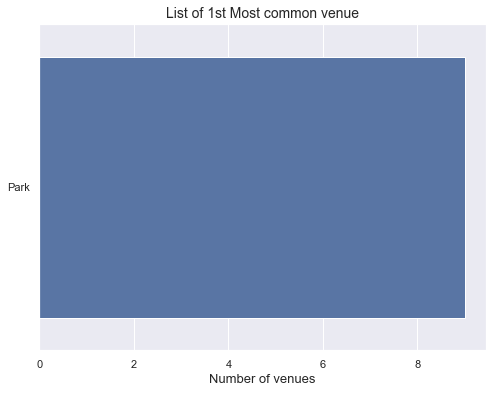

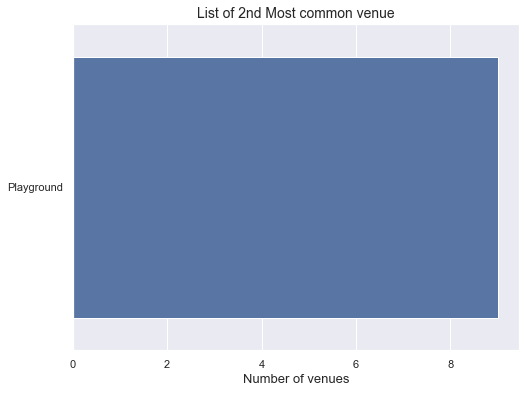

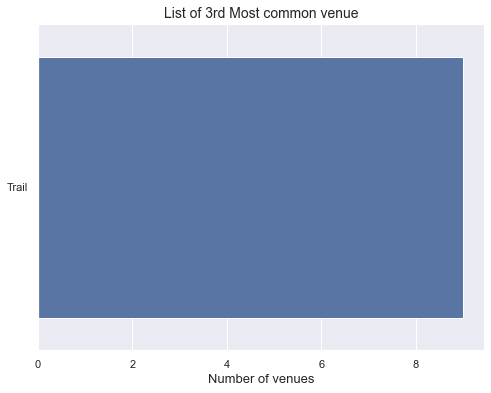

In [99]:
# cluster 2
cluster3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(4, toronto_merged.shape[1]))]]
df = cluster3
for col in df.loc[:, '1st Most common venue':]:
    venue_category_plot(col)

In [106]:
cluster3.shape

(9, 4)

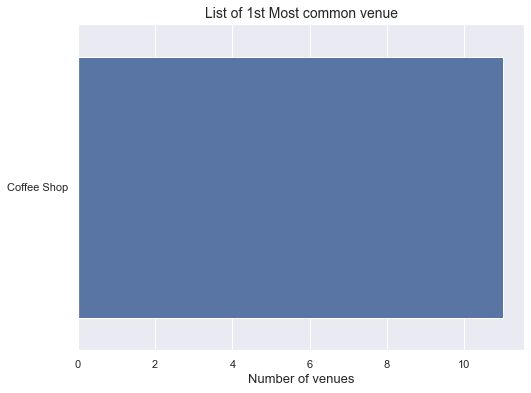

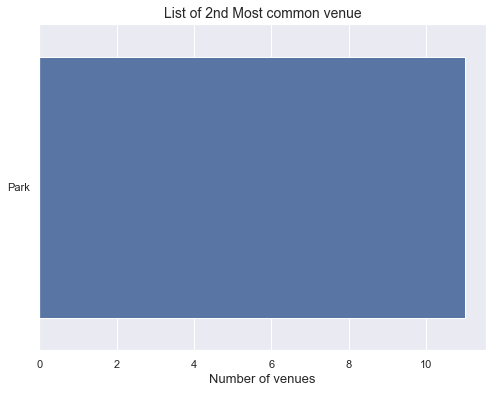

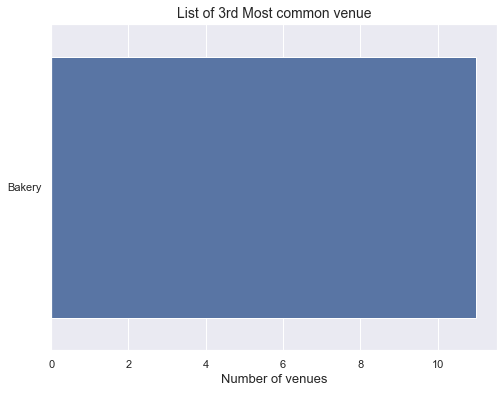

In [100]:
# cluster 3
cluster4 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(4, toronto_merged.shape[1]))]]
df = cluster4
for col in df.loc[:, '1st Most common venue':]:
    venue_category_plot(col)

In [107]:
cluster4.shape

(11, 4)

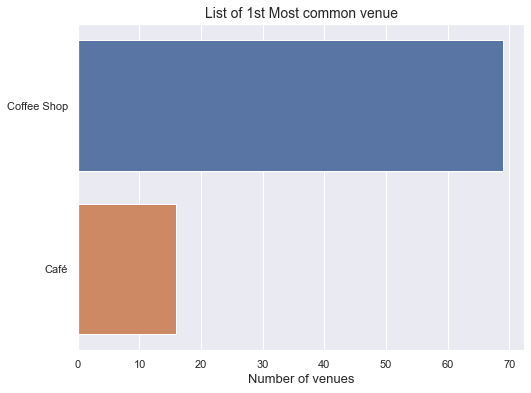

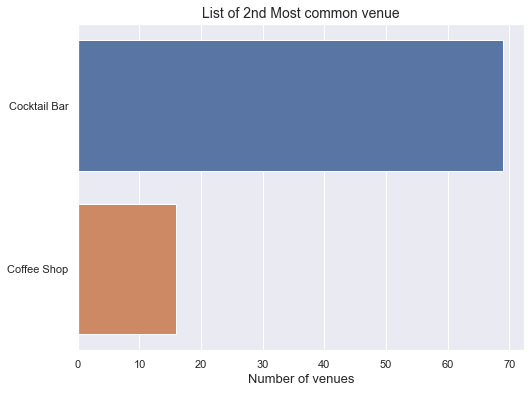

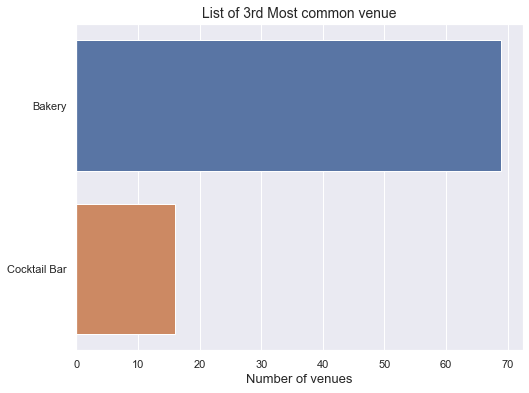

In [101]:
# cluster 4
cluster5 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(4, toronto_merged.shape[1]))]]
df = cluster5
for col in df.loc[:, '1st Most common venue':]:
    venue_category_plot(col)

In [108]:
cluster5.shape

(85, 4)

### Pick cluster 1, create map of all listings in cluster 1

In [115]:
# create map
first_cluster = folium.Map(location=[toronto_merged['Listing Latitude'].mean(), 
                          toronto_merged['Listing Longitude'].mean()], zoom_start=12)

# show only listings in cluster 1
df_lists = toronto_merged[toronto_merged['Cluster Labels'] == 1]

# create list of listings location
locate = df_lists[['Listing Latitude', 'Listing Longitude']]
locate_list = locate.values.tolist()

mc = MarkerCluster().add_to(first_cluster)

# add markers to map
for lat, lng, neighbourhood in zip(df_lists['Listing Latitude'], df_lists['Listing Longitude'], df_lists['Neighbourhood']):
    label='Listing neighbourhood: {}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
                       radius=5,
                       popup=label,
                       color='blue',
                       fill=True,
                       fill_color='#318cc',
                       fill_opacity=0.7,
                       parse_html=False).add_to(mc)


#first_cluster
embed_map(first_cluster,'first_cluster.html')